# Crafting adversarial examples for the fashion MNIST dataset
        Eritz Yerga Gutierrez
***
The goal of this project is to implement one or more approaches to create adversarial examples for the [fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. 

## 1. Importing the libraries and dataset
To run this notebook the following libraries must be installed:
* Numpy
* Matplotlib
* [Tensorflow](https://www.tensorflow.org)
* [Tensorflow-Adversarial](https://github.com/gongzhitaao/tensorflow-adversarial)

Numpy, Matplotlib and Tensorflow can be installed trough pip. 

However, Tensorflow-Adversarial **must be installed manually**, copy "fast_gradient.py", "saliency_map.py" and "deepfool.py" from the ["attacks" folder](https://github.com/gongzhitaao/tensorflow-adversarial/tree/master/attacks) to the same folder this notebook is located or IT WILL NOT WORK.

The [fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset must be downloaded from [these links](https://github.com/zalandoresearch/fashion-mnist#get-the-data) and those files must be placed in the "data/fashion" directory, otherwise tensorflow will load the original MNIST.

Now we can import the neeeded libraries:

In [1]:
import itertools 
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import fast_gradient as fg
import saliency_map as sm
import deepfool as df

Import the dataset:

In [2]:
# We define the characteristics of the input image 
height = 28
width = 28
channels = 1
input_shape = (width, height, channels)
n_inputs = height * width
n_classes = 10

In [3]:
data = input_data.read_data_sets('data/fashion', one_hot=True)

# Define train and test sets
X_train = data.train.images
X_test = data.test.images
y_train = data.train.labels.astype("int")
y_test = data.test.labels.astype("int")

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(-1, width, height, channels)
X_test = X_test.reshape(-1, width, height, channels)

def get_start_end(ind, batch_size, n_sample):
    start = ind*batch_size
    end = min(n_sample, start+batch_size)
    return start, end

Extracting data/fashion\train-images-idx3-ubyte.gz
Extracting data/fashion\train-labels-idx1-ubyte.gz
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz


And create a dictionary with the definition of the dataset to have readable classes:

In [4]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

With this cell we can check some samples to see if the dataset loaded correctly:

Train samples:
y = 3 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.] (Dress)


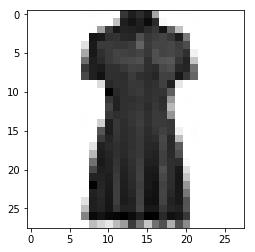

y = 7 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.] (Sneaker)


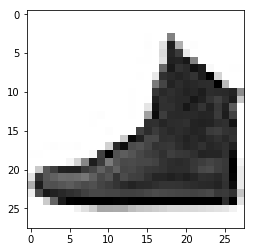

Test samples:
y = 4 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.] (Coat)


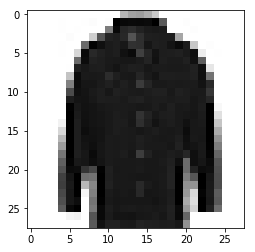

y = 8 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.] (Bag)


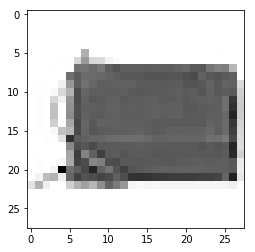

In [5]:
# Select samples to view
samples_train = [47, 23]
samples_test = [14, 18]

# Plot samples
print("Train samples:")
for s in samples_train:
    sample = data.train.images[s].reshape(28,28)
    sample_label = data.train.labels[s]
    print("y = {label_index} {label_vec} ({label})".format(label_index=np.argmax(sample_label, axis=0), label_vec=sample_label, label=label_dict[np.argmax(sample_label, axis=0)]))
    plt.imshow(sample, cmap='Greys')
    plt.show()
print("Test samples:")
for s in samples_test:
    sample = data.test.images[s].reshape(28,28)
    sample_label = data.test.labels[s]
    print("y = {label_index} {label_vec} ({label})".format(label_index=np.argmax(sample_label, axis=0), label_vec=sample_label, label=label_dict[np.argmax(sample_label, axis=0)]))
    plt.imshow(sample, cmap='Greys')
    plt.show()

## 2. Defining the model

Here you can chose if you want to use a GPU (**needs a GPU with more than 4GB of memory!**) or use the CPU:

In [28]:
# Set to True if you want to use a GPU for computing
UseGPU = False

In [29]:
if UseGPU:
    config = tf.ConfigProto(device_count = {'GPU': 1})
else:
    config = tf.ConfigProto(device_count = {'GPU': 0})

### The model:
A Convolutional Neural Network (Deep Learning) was chosen with the following layers:
* conv1: Convolutional layer
* pool1: Max-pooling layer
* conv2: Convolutional layer
* pool2: Max-pooling layer
* dense1: Full layer with 128 units (with dropout)
* dense2: Full layer with 64 units (with dropout)

Softmax function as the output function.

In [30]:
def model(x, logits=False, training=False):
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3], padding='SAME', name='conv1', activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2], strides=2, name='pool1')
    
    conv2 = tf.layers.conv2d(pool1, filters=64, kernel_size=[3, 3], padding='SAME', name='conv2', activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(conv2, pool_size=[2, 2], strides=2, name='pool2')
    
    flat = tf.reshape(pool2, [-1, 7*7*64], name='flatten')
    
    dense1 = tf.layers.dense(flat, units=128, activation=tf.nn.relu, name='dense1')
    dropout1 = tf.layers.dropout(dense1, rate=0.25, training=training, name='dropout1')
    dense2 = tf.layers.dense(dropout1, units=64, activation=tf.nn.relu, name='dense2')
    dropout2 = tf.layers.dropout(dense2, rate=0.30, training=training, name='dropout2')
    
    logits_ = tf.layers.dense(dropout2, units=10, name='logits')
    y = tf.nn.softmax(logits_, name='ybar')
    
    if logits:
        return y, logits_
    return y

Now we define our TensorFlow graph and define the input placeholders, the outputs, the optimizer, the saver...

In [31]:
tf.reset_default_graph()
class Dummy:
    pass
env = Dummy()

with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, width, height, channels), name='x')
    env.y = tf.placeholder(tf.int32, (None, n_classes), name='y')
    env.training = tf.placeholder(bool, (), name='mode')

    env.ybar, logits = model(env.x, logits=True, training=env.training)

    truez = tf.argmax(env.y, axis=1)
    predictedz = tf.argmax(env.ybar, axis=1)
    
    count = tf.cast(tf.equal(truez, predictedz), tf.float32)
    env.acc = tf.reduce_mean(count, name='acc')
    xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y, logits=logits)
    env.loss = tf.reduce_mean(xent, name='loss')
    
    with tf.name_scope("eval"):
        accuracy = tf.reduce_mean(tf.cast(count, tf.float32))
        
    with tf.name_scope("save"):
        saver = tf.train.Saver()
    
env.optimizer = tf.train.AdamOptimizer().minimize(env.loss)

### The adversarial attacking operations:
We will also define the operations we will later run to generate the adversarial examples.

In [32]:
with tf.variable_scope('model', reuse=True):
    env.adv_fgm = fg.fgm(model, env.x)
    env.adv_jsma_t0 = sm.jsma(model, env.x, 0)
    env.adv_jsma_t1 = sm.jsma(model, env.x, 1)
    env.adv_jsma_t2 = sm.jsma(model, env.x, 2)
    env.adv_jsma_t3 = sm.jsma(model, env.x, 3)
    env.adv_jsma_t4 = sm.jsma(model, env.x, 4)
    env.adv_jsma_t5 = sm.jsma(model, env.x, 5)
    env.adv_jsma_t6 = sm.jsma(model, env.x, 6)
    env.adv_jsma_t7 = sm.jsma(model, env.x, 7)
    env.adv_jsma_t8 = sm.jsma(model, env.x, 8)
    env.adv_jsma_t9 = sm.jsma(model, env.x, 9)
    env.adv_df = df.deepfool(model, env.x)

## 3. Training the model
We feed batches from the train part of the dataset to our model and check the accuracy against the train batches and the test part of the dataset.

We will train the model for *n_epoch* number of epoches, with batches of *BATCH_SIZE* images. (These parameters can be adjusted if wanted)

The model is loaded from the provided model if *LoadModel* is set to True. The model can be saved if the flag *SaveModel* is set to True.

In [35]:
LoadModel = True
SaveModel = False
n_epochs = 30
BATCH_SIZE = 100

And now we run the training process:

In [34]:
n_train = X_train.shape[0]
n_batch = int(np.ceil(n_train/BATCH_SIZE))

sess = tf.Session(config=config)
with sess.as_default():
    if LoadModel:
        saver.restore(sess, "./fashion_mnist_cnn.model")
        print("Model loaded!")
    else:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        for epoch in range(n_epochs):
            acc_train = 0.0
            for iteration in range(n_batch):
                start, end = get_start_end(iteration, BATCH_SIZE, n_train)
                sess.run(env.optimizer, feed_dict={env.x: X_train[start:end], env.y: y_train[start:end], env.training: True})
                acc_train += accuracy.eval(feed_dict={env.x: X_train[start:end], env.y: y_train[start:end], env.training: False})

            acc_train = (acc_train / float(n_batch))

            acc_test = accuracy.eval(feed_dict={env.x: X_test, env.y: y_test, env.training: False})
            print("[", epoch+1, "] Train accuracy:", acc_train, "Test accuracy:", acc_test)

[ 1 ] Train accuracy: 0.572109092399 Test accuracy: 0.7274
[ 2 ] Train accuracy: 0.751909090281 Test accuracy: 0.7499
[ 3 ] Train accuracy: 0.773909087831 Test accuracy: 0.7739
[ 4 ] Train accuracy: 0.792745452469 Test accuracy: 0.7847
[ 5 ] Train accuracy: 0.809927269871 Test accuracy: 0.8042
[ 6 ] Train accuracy: 0.823090907769 Test accuracy: 0.8112
[ 7 ] Train accuracy: 0.834036362388 Test accuracy: 0.8238
[ 8 ] Train accuracy: 0.841545454155 Test accuracy: 0.8314
[ 9 ] Train accuracy: 0.847745453228 Test accuracy: 0.8402
[ 10 ] Train accuracy: 0.853418180617 Test accuracy: 0.8465
[ 11 ] Train accuracy: 0.857454544089 Test accuracy: 0.8469
[ 12 ] Train accuracy: 0.861327271678 Test accuracy: 0.8519
[ 13 ] Train accuracy: 0.864800000082 Test accuracy: 0.8512
[ 14 ] Train accuracy: 0.867927272103 Test accuracy: 0.8553
[ 15 ] Train accuracy: 0.870400000811 Test accuracy: 0.8581
[ 16 ] Train accuracy: 0.874309089834 Test accuracy: 0.8637
[ 17 ] Train accuracy: 0.876200000048 Test accura

In [36]:
if SaveModel:
    save_path = saver.save(sess, "./fashion_mnist_cnn.model")
    print("Model saved!")

Model saved!


## 4. Generating the adversarial examples
We will test the two adversarial attack types:
* Untargeted attacks (FGM and DeepFool)
* Targeted attacks (JSMA)

The methods used for generating adversarial examples for these attacks will be:
* Fast Gradient Method (SGM)
* Jacobian-based Saliency Map Approach (JSMA)
* DeepFool

We will generate the adversarial test batches to test the accuracy:

In [37]:
with sess.as_default():
    adv_test_fgm = sess.run(env.adv_fgm, feed_dict={env.x: X_test, env.y: y_test, env.training: False})
    adv_test_jsma = sess.run(env.adv_jsma_t0, feed_dict={env.x: X_test, env.y: y_test, env.training: False})
    adv_test_df = sess.run(env.adv_df, feed_dict={env.x: X_test, env.y: y_test, env.training: False})

We will also define a wrapper function for later use in the visual testing part:

In [38]:
def SELECT_JSMA(target_class):
    if (target_class == 1): return env.adv_jsma_t1
    elif (target_class == 2): return env.adv_jsma_t2
    elif (target_class == 3): return env.adv_jsma_t3
    elif (target_class == 4): return env.adv_jsma_t4
    elif (target_class == 5): return env.adv_jsma_t5
    elif (target_class == 6): return env.adv_jsma_t6
    elif (target_class == 7): return env.adv_jsma_t7
    elif (target_class == 8): return env.adv_jsma_t8
    elif (target_class == 9): return env.adv_jsma_t9
    else: return env.adv_jsma_t0

## 5. Validation
We will test the result of the adversarial attacks, these tests will consist on:
* Visual testing (to see what happens to the images and what our CNN predicts as the most probable class)
* Accuracy testing (to see the results to the CNN predictions)

### Visual testing
We will see what the CNN predicts with an image subject to the selected adversarial attacks. We can modify the *test_target* variable to choose different images.

In [39]:
# We select the image we want to test with:
target_test = 32
target_image = X_test[target_test-1:target_test]
target_label = y_test[target_test-1:target_test]

##### Prediction with unaltered image

y = 8 [0 0 0 0 0 0 0 0 1 0] (Bag)


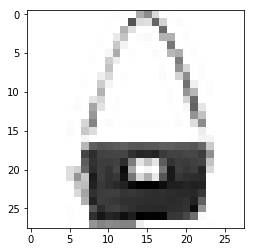

Predicted = 8 (Bag)


In [40]:
# Predict with normal test image:
with sess.as_default():
    best = sess.run(predictedz, feed_dict={env.x: target_image, env.training: False})
    print("y = {label_index} {label_vec} ({label})".format(label_index=np.argmax(target_label[0], axis=0), label_vec=target_label[0], label=label_dict[np.argmax(target_label[0], axis=0)]))
    plt.imshow(target_image[0].reshape(28,28), cmap='Greys')
    plt.show()
    print("Predicted = "+str(best[0])+" ("+str(label_dict[best[0]])+")")

##### Prediction with an image subjected to a untargeted FGM attack

y = 8 [0 0 0 0 0 0 0 0 1 0] (Bag)


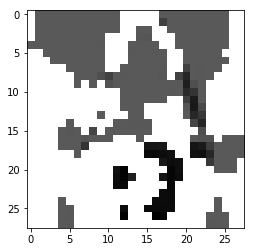

Predicted = 1 (Trouser)


In [41]:
# Try to predict with untargeted FGM attack
with sess.as_default():
    res = sess.run(env.adv_fgm, feed_dict={env.x: target_image})
    best = sess.run(predictedz, feed_dict={env.x: res, env.training: False})
    print("y = {label_index} {label_vec} ({label})".format(label_index=np.argmax(target_label[0], axis=0), label_vec=target_label[0], label=label_dict[np.argmax(target_label[0], axis=0)]))
    plt.imshow(res.reshape(28,28), cmap='Greys')
    plt.show()
    print("Predicted = "+str(best[0])+" ("+str(label_dict[best[0]])+")")

##### Prediction with an image subjected to a targeted* JSMA attack

*Change target_class to select the target class.

y = 8 [0 0 0 0 0 0 0 0 1 0] (Bag)


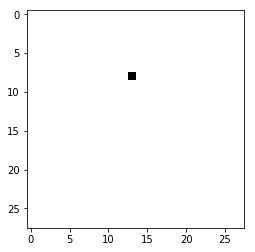

Predicted = 5 (Sandal)


In [47]:
# Try to predict with targeted JSMA attack

# We can change target_class to direct the JSMA attack to that class
target_class = 0

with sess.as_default():
    res = sess.run(SELECT_JSMA(target_class), feed_dict={env.x: target_image})
    best = sess.run(predictedz, feed_dict={env.x: res, env.training: False})
    print("y = {label_index} {label_vec} ({label})".format(label_index=np.argmax(target_label[0], axis=0), label_vec=target_label[0], label=label_dict[np.argmax(target_label[0], axis=0)]))
    plt.imshow(res.reshape(28,28), cmap='Greys')
    plt.show()
    print("Predicted = "+str(best[0])+" ("+str(label_dict[best[0]])+")")

##### Prediction with an image subjected to a untargeted DeepFool attack

y = 8 [0 0 0 0 0 0 0 0 1 0] (Bag)


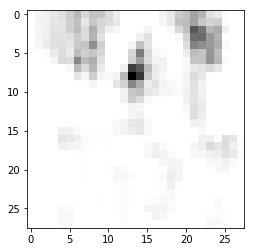

Predicted = 0 (T-shirt/top)


In [43]:
# Try to predict with untargeted DeepFool attack
with sess.as_default():
    res = sess.run(env.adv_df, feed_dict={env.x: target_image})
    best = sess.run(predictedz, feed_dict={env.x: res, env.training: False})
    print("y = {label_index} {label_vec} ({label})".format(label_index=np.argmax(target_label[0], axis=0), label_vec=target_label[0], label=label_dict[np.argmax(target_label[0], axis=0)]))
    plt.imshow(res.reshape(28,28), cmap='Greys')
    plt.show()
    print("Predicted = "+str(best[0])+" ("+str(label_dict[best[0]])+")")

### Accuracy testing
We will test with the previously crafted adversarial test examples to see the CNNs accuracy:

In [44]:
with sess.as_default():
    acc = accuracy.eval(feed_dict={env.x: X_test, env.y: y_test, env.training: False})
    acc_adv_fgm = accuracy.eval(feed_dict={env.x: adv_test_fgm, env.y: y_test, env.training: False})
    acc_adv_jsma = accuracy.eval(feed_dict={env.x: adv_test_jsma, env.y: y_test, env.training: False})
    acc_adv_df = accuracy.eval(feed_dict={env.x: adv_test_df, env.y: y_test, env.training: False})
    
    print("Test accuracy:", acc)
    print("Test accuracy for adversarial FGM examples:", acc_adv_fgm)
    print("Test accuracy for adversarial JSMA examples:", acc_adv_jsma)
    print("Test accuracy for adversarial DeepFool examples:", acc_adv_df)

Test accuracy: 0.8837
Test accuracy for adversarial FGM examples: 0.0565
Test accuracy for adversarial JSMA examples: 0.122
Test accuracy for adversarial DeepFool examples: 0.0514
